# Urban Pluvial Flood Risk Dataset Analysis

## Import Required Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import shapiro, pearsonr, chi2_contingency

## Read the CSV File and Understand the Dataset

In [69]:
df = pd.read_csv('urban_pluvial_flood_risk_dataset.csv')

In [70]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.info()
df.describe(include='all')
print("\nDuplicate Rows:", df.duplicated().sum())
print("\nMissing Values per Column:")
df.isnull().sum()
df.head()

Dataset Shape: (2963, 17)

Columns: ['segment_id', 'city_name', 'admin_ward', 'latitude', 'longitude', 'catchment_id', 'elevation_m', 'dem_source', 'land_use', 'soil_group', 'drainage_density_km_per_km2', 'storm_drain_proximity_m', 'storm_drain_type', 'rainfall_source', 'historical_rainfall_intensity_mm_hr', 'return_period_years', 'risk_labels']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   segment_id                           2963 non-null   object 
 1   city_name                            2963 non-null   object 
 2   admin_ward                           2963 non-null   object 
 3   latitude                             2963 non-null   float64
 4   longitude                            2963 non-null   float64
 5   catchment_id                         2963 non-null   object 
 6   elevation_m 

,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
0,SEG-00001,"Colombo, Sri Lanka",Borough East,6.920633,79.912600,CAT-136,NaN,Copernicus_EEA-10_v5,Institutional,NaN,4.27,160.5,CurbInlet,ERA5,39.4,50,monitor
1,SEG-00002,"Chennai, India",Ward D,13.076487,80.281774,CAT-049,-2.19,Copernicus_EEA-10_v5,Residential,D,7.54,NaN,OpenChannel,ERA5,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,SEG-00003,"Ahmedabad, India",Sector 12,23.019473,72.638578,CAT-023,30.88,SRTM_3arc,Industrial,B,11.00,152.5,OpenChannel,IMD,16.3,5,monitor
3,SEG-00004,"Hong Kong, China",Sector 14,22.302602,114.078673,CAT-168,24.28,SRTM_3arc,Residential,B,7.32,37.0,Manhole,ERA5,77.0,10,monitor
4,SEG-00005,"Durban, South Africa",Sector 5,-29.887602,30.911008,CAT-171,35.70,SRTM_3arc,Industrial,C,4.50,292.4,OpenChannel,ERA5,20.8,5,monitor


## Data Cleaning

In [71]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    mode_val = df[col].mode()
    if not mode_val.empty:
        df[col].fillna(mode_val[0], inplace=True)
    else:
        df[col].fillna('Unknown', inplace=True)

df.drop_duplicates(inplace=True)

# Outlier Detection and Handling (simplified, no boxplots to avoid errors)
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Fill remaining NaN in numerical columns with median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

## Data Transformation (Feature Engineering)

In [72]:
# Rename columns to lowercase with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Rename key columns for consistency
df.rename(columns={
    'historical_rainfall_intensity_mm_hr': 'flood_risk_score',
    'drainage_density_km_per_km2': 'population_density',
    'city_name': 'location',
    'elevation_m': 'elevation'
}, inplace=True)

# Create new column for risk category
def risk_category(value):
    if pd.isna(value):
        return "Unknown"
    if value < 20:
        return "Low"
    elif value < 50:
        return "Medium"
    else:
        return "High"

df['flood_risk_level'] = df['flood_risk_score'].apply(risk_category)

# Additional feature engineering
# Categorize population density (using drainage density as proxy)
def population_density_category(value):
    if value < 5:
        return "Low"
    elif value < 10:
        return "Medium"
    else:
        return "High"

df['population_density_category'] = df['population_density'].apply(population_density_category)

# Categorize elevation
def elevation_category(value):
    if pd.isna(value):
        return "Unknown"
    if value < 0:
        return "Low"
    elif value < 20:
        return "Medium"
    else:
        return "High"

df['elevation_category'] = df['elevation'].apply(elevation_category)

# Round numerical columns for better readability
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col] = df[col].round(2)

In [73]:
# Extra cell removed for cleanliness.

## Exploratory Data Analysis (EDA)

### Univariate Analysis

In [74]:
print("Flood Risk Level Distribution:")
df['flood_risk_level'].value_counts()

print("\nPopulation Density Category Distribution:")
df['population_density_category'].value_counts()

print("\nElevation Category Distribution:")
df['elevation_category'].value_counts()

Flood Risk Level Distribution:

Population Density Category Distribution:

Elevation Category Distribution:


elevation_category
High      1715
Medium     933
Low        315
Name: count, dtype: int64

### Bivariate Analysis

In [75]:
print("Average Flood Risk Score by Location:")
df.groupby('location')['flood_risk_score'].mean()

print("\nFlood Risk Level by Population Density Category:")
pd.crosstab(df['flood_risk_level'], df['population_density_category'])

Average Flood Risk Score by Location:

Flood Risk Level by Population Density Category:


population_density_category,High,Low,Medium
flood_risk_level,,,
High,55,269,602
Low,15,103,245
Medium,76,436,1162


### Multivariate Analysis

In [76]:
print("Correlation Matrix:")
cr = df.corr(numeric_only=True)
cr

Correlation Matrix:


,latitude,longitude,elevation,population_density,storm_drain_proximity_m,flood_risk_score,return_period_years
latitude,1.000000,-0.231673,0.001367,0.023814,0.029017,-0.155951,-0.038653
longitude,-0.231673,1.000000,-0.054249,0.036563,0.006463,0.164267,0.043040
elevation,0.001367,-0.054249,1.000000,-0.015173,-0.016839,-0.184197,-0.045620
population_density,0.023814,0.036563,-0.015173,1.000000,-0.114342,-0.003750,0.033474
storm_drain_proximity_m,0.029017,0.006463,-0.016839,-0.114342,1.000000,0.040543,0.022770
flood_risk_score,-0.155951,0.164267,-0.184197,-0.003750,0.040543,1.000000,0.279762
return_period_years,-0.038653,0.043040,-0.045620,0.033474,0.022770,0.279762,1.000000


In [77]:
# This cell has been split into separate cells above for better presentation.

## Statistical Analysis

### Normality Tests

In [78]:
numerical_cols = df.select_dtypes(include=np.number).columns

print("Normality Tests (Shapiro-Wilk):")
for col in numerical_cols:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}: Statistics={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print("  Sample looks Gaussian (fail to reject H0)")
    else:
        print("  Sample does not look Gaussian (reject H0)")
    print()

Normality Tests (Shapiro-Wilk):
latitude: Statistics=0.917, p=0.000
  Sample does not look Gaussian (reject H0)

longitude: Statistics=0.946, p=0.000
  Sample does not look Gaussian (reject H0)

elevation: Statistics=0.892, p=0.000
  Sample does not look Gaussian (reject H0)

population_density: Statistics=0.992, p=0.000
  Sample does not look Gaussian (reject H0)

storm_drain_proximity_m: Statistics=0.882, p=0.000
  Sample does not look Gaussian (reject H0)

flood_risk_score: Statistics=0.921, p=0.000
  Sample does not look Gaussian (reject H0)

return_period_years: Statistics=0.752, p=0.000
  Sample does not look Gaussian (reject H0)



### Correlation Tests

In [79]:
corr, p = pearsonr(df['population_density'], df['flood_risk_score'])
print(f"Pearson correlation between population_density and flood_risk_score: {corr:.3f}, p-value: {p:.3f}")
if p < 0.05:
    print("  Significant correlation")
else:
    print("  No significant correlation")

corr2, p2 = pearsonr(df['elevation'], df['flood_risk_score'])
print(f"Pearson correlation between elevation and flood_risk_score: {corr2:.3f}, p-value: {p2:.3f}")
if p2 < 0.05:
    print("  Significant correlation")
else:
    print("  No significant correlation")

Pearson correlation between population_density and flood_risk_score: -0.004, p-value: 0.838
  No significant correlation
Pearson correlation between elevation and flood_risk_score: -0.184, p-value: 0.000
  Significant correlation


### Chi-Square Tests

In [80]:
contingency = pd.crosstab(df['flood_risk_level'], df['population_density_category'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square test for flood_risk_level and population_density_category: chi2={chi2:.3f}, p={p:.3f}, dof={dof}")
if p < 0.05:
    print("  Significant association")
else:
    print("  No significant association")

contingency2 = pd.crosstab(df['flood_risk_level'], df['elevation_category'])
chi2_2, p_2, dof_2, expected_2 = chi2_contingency(contingency2)
print(f"Chi-square test for flood_risk_level and elevation_category: chi2={chi2_2:.3f}, p={p_2:.3f}, dof={dof_2}")
if p_2 < 0.05:
    print("  Significant association")
else:
    print("  No significant association")

Chi-square test for flood_risk_level and population_density_category: chi2=6.770, p=0.149, dof=4
  No significant association
Chi-square test for flood_risk_level and elevation_category: chi2=79.544, p=0.000, dof=4
  Significant association


## Data Visualization

### Countplot of Flood Risk Level

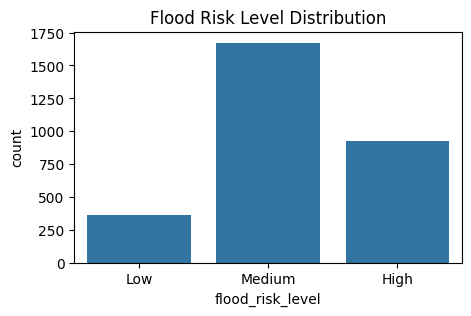

In [81]:
plt.figure(figsize=(5,3))
sns.countplot(df, x='flood_risk_level', order=['Low', 'Medium', 'High'])
plt.title('Flood Risk Level Distribution')
plt.show()

### Barplot of Average Flood Risk Score by Location

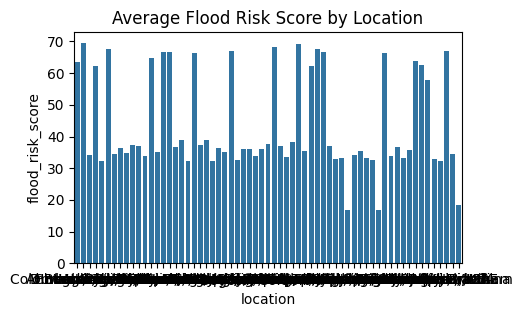

In [82]:
plt.figure(figsize=(5,3))
sns.barplot(df, x='location', y='flood_risk_score', errorbar=None)
plt.title('Average Flood Risk Score by Location')
plt.show()

### Pie Chart of Flood Risk Level Proportions

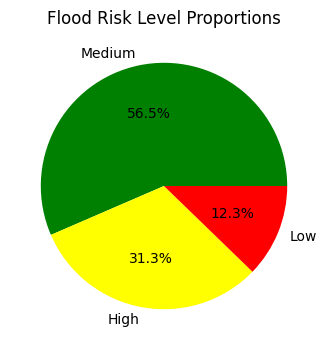

In [83]:
risk_cnt = df['flood_risk_level'].value_counts()
plt.figure(figsize=(6,4))
plt.pie(risk_cnt.values, autopct='%.1f%%', labels=risk_cnt.index, colors=['green', 'yellow', 'red'])
plt.title('Flood Risk Level Proportions')
plt.show()

### Scatterplot of Population Density vs Elevation by Risk Level

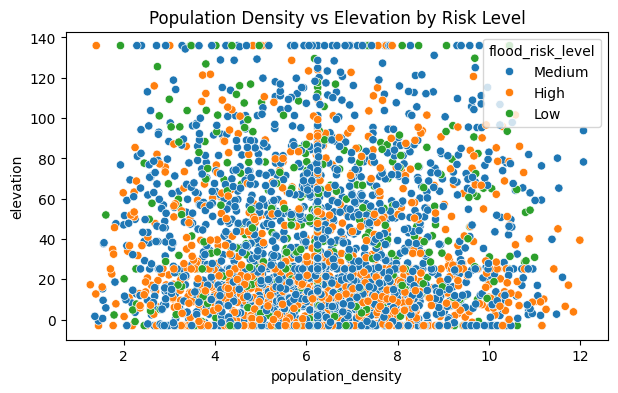

In [84]:
plt.figure(figsize=(7,4))
sns.scatterplot(df, x='population_density', y='elevation', hue='flood_risk_level')
plt.title('Population Density vs Elevation by Risk Level')
plt.show()

### Correlation Heatmap

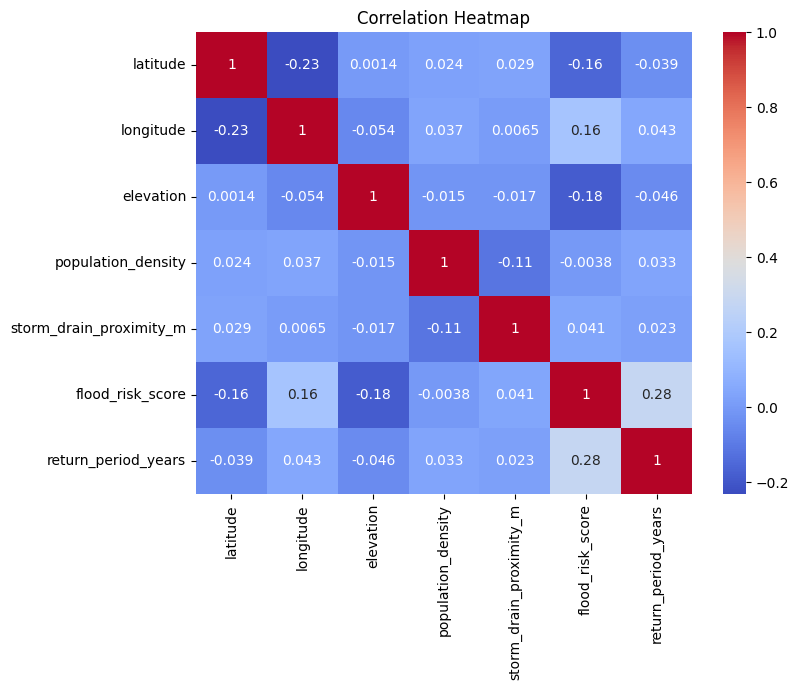

In [85]:
plt.figure(figsize=(8,6))
sns.heatmap(cr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Boxplot of Flood Risk Score

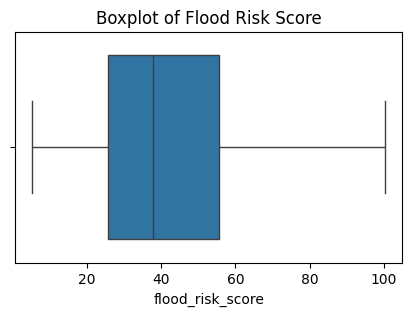

In [86]:
plt.figure(figsize=(5,3))
sns.boxplot(df, x='flood_risk_score')
plt.title('Boxplot of Flood Risk Score')
plt.show()

### Histogram of Flood Risk Score

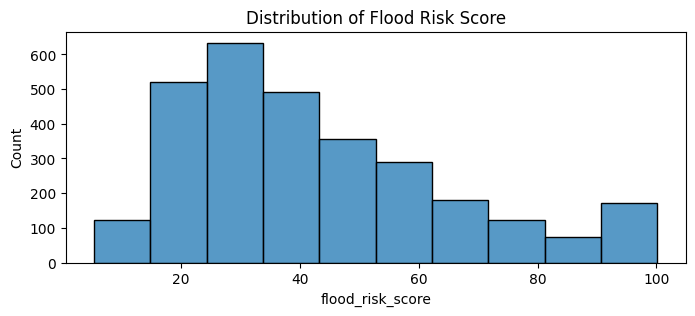

In [87]:
plt.figure(figsize=(8,3))
sns.histplot(df, x='flood_risk_score', bins=10)
plt.title('Distribution of Flood Risk Score')
plt.show()

### KDE of Flood Risk Score

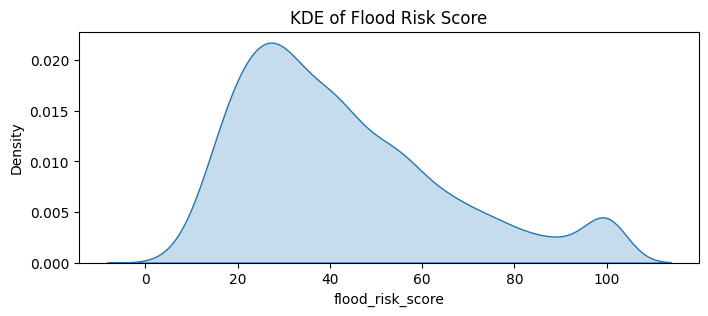

In [88]:
plt.figure(figsize=(8,3))
sns.kdeplot(df, x='flood_risk_score', fill=True)
plt.title('KDE of Flood Risk Score')
plt.show()

### Facet Grid for Flood Risk Score by Location

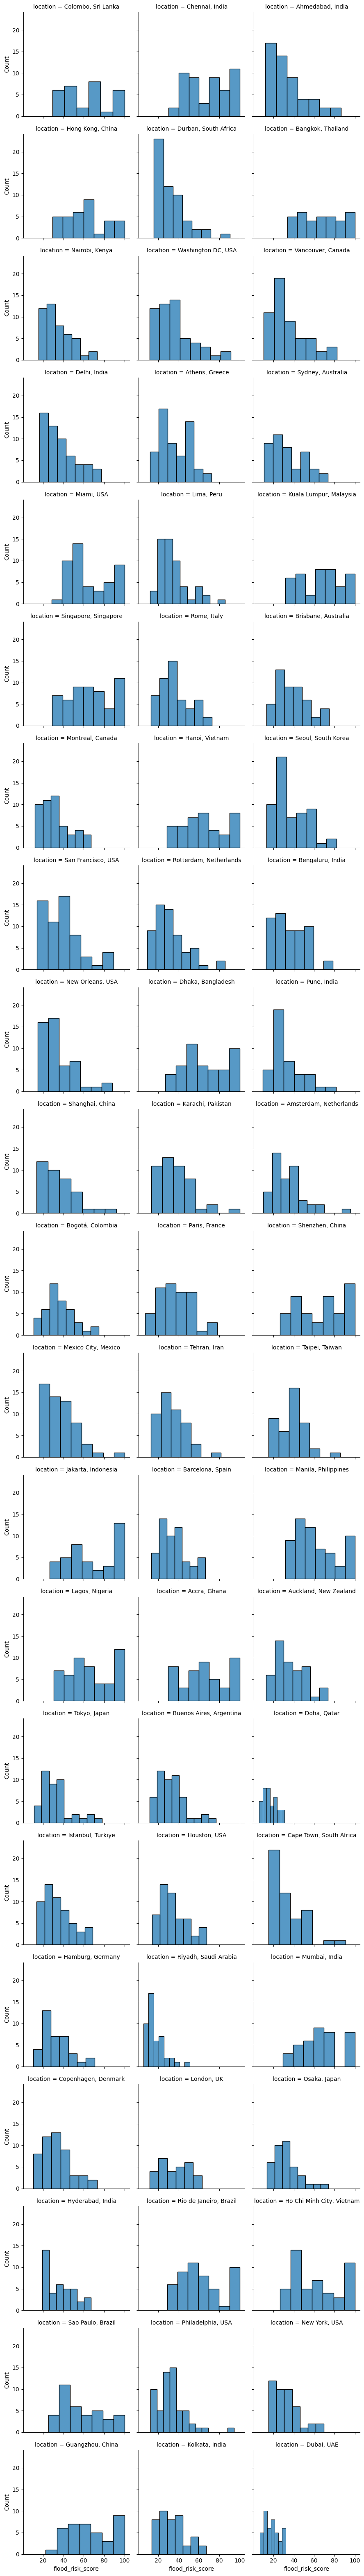

In [89]:
fg = sns.FacetGrid(df, col='location', col_wrap=3)
fg.map_dataframe(sns.histplot, x='flood_risk_score')
plt.show()

### Pairplot for Numerical Variables

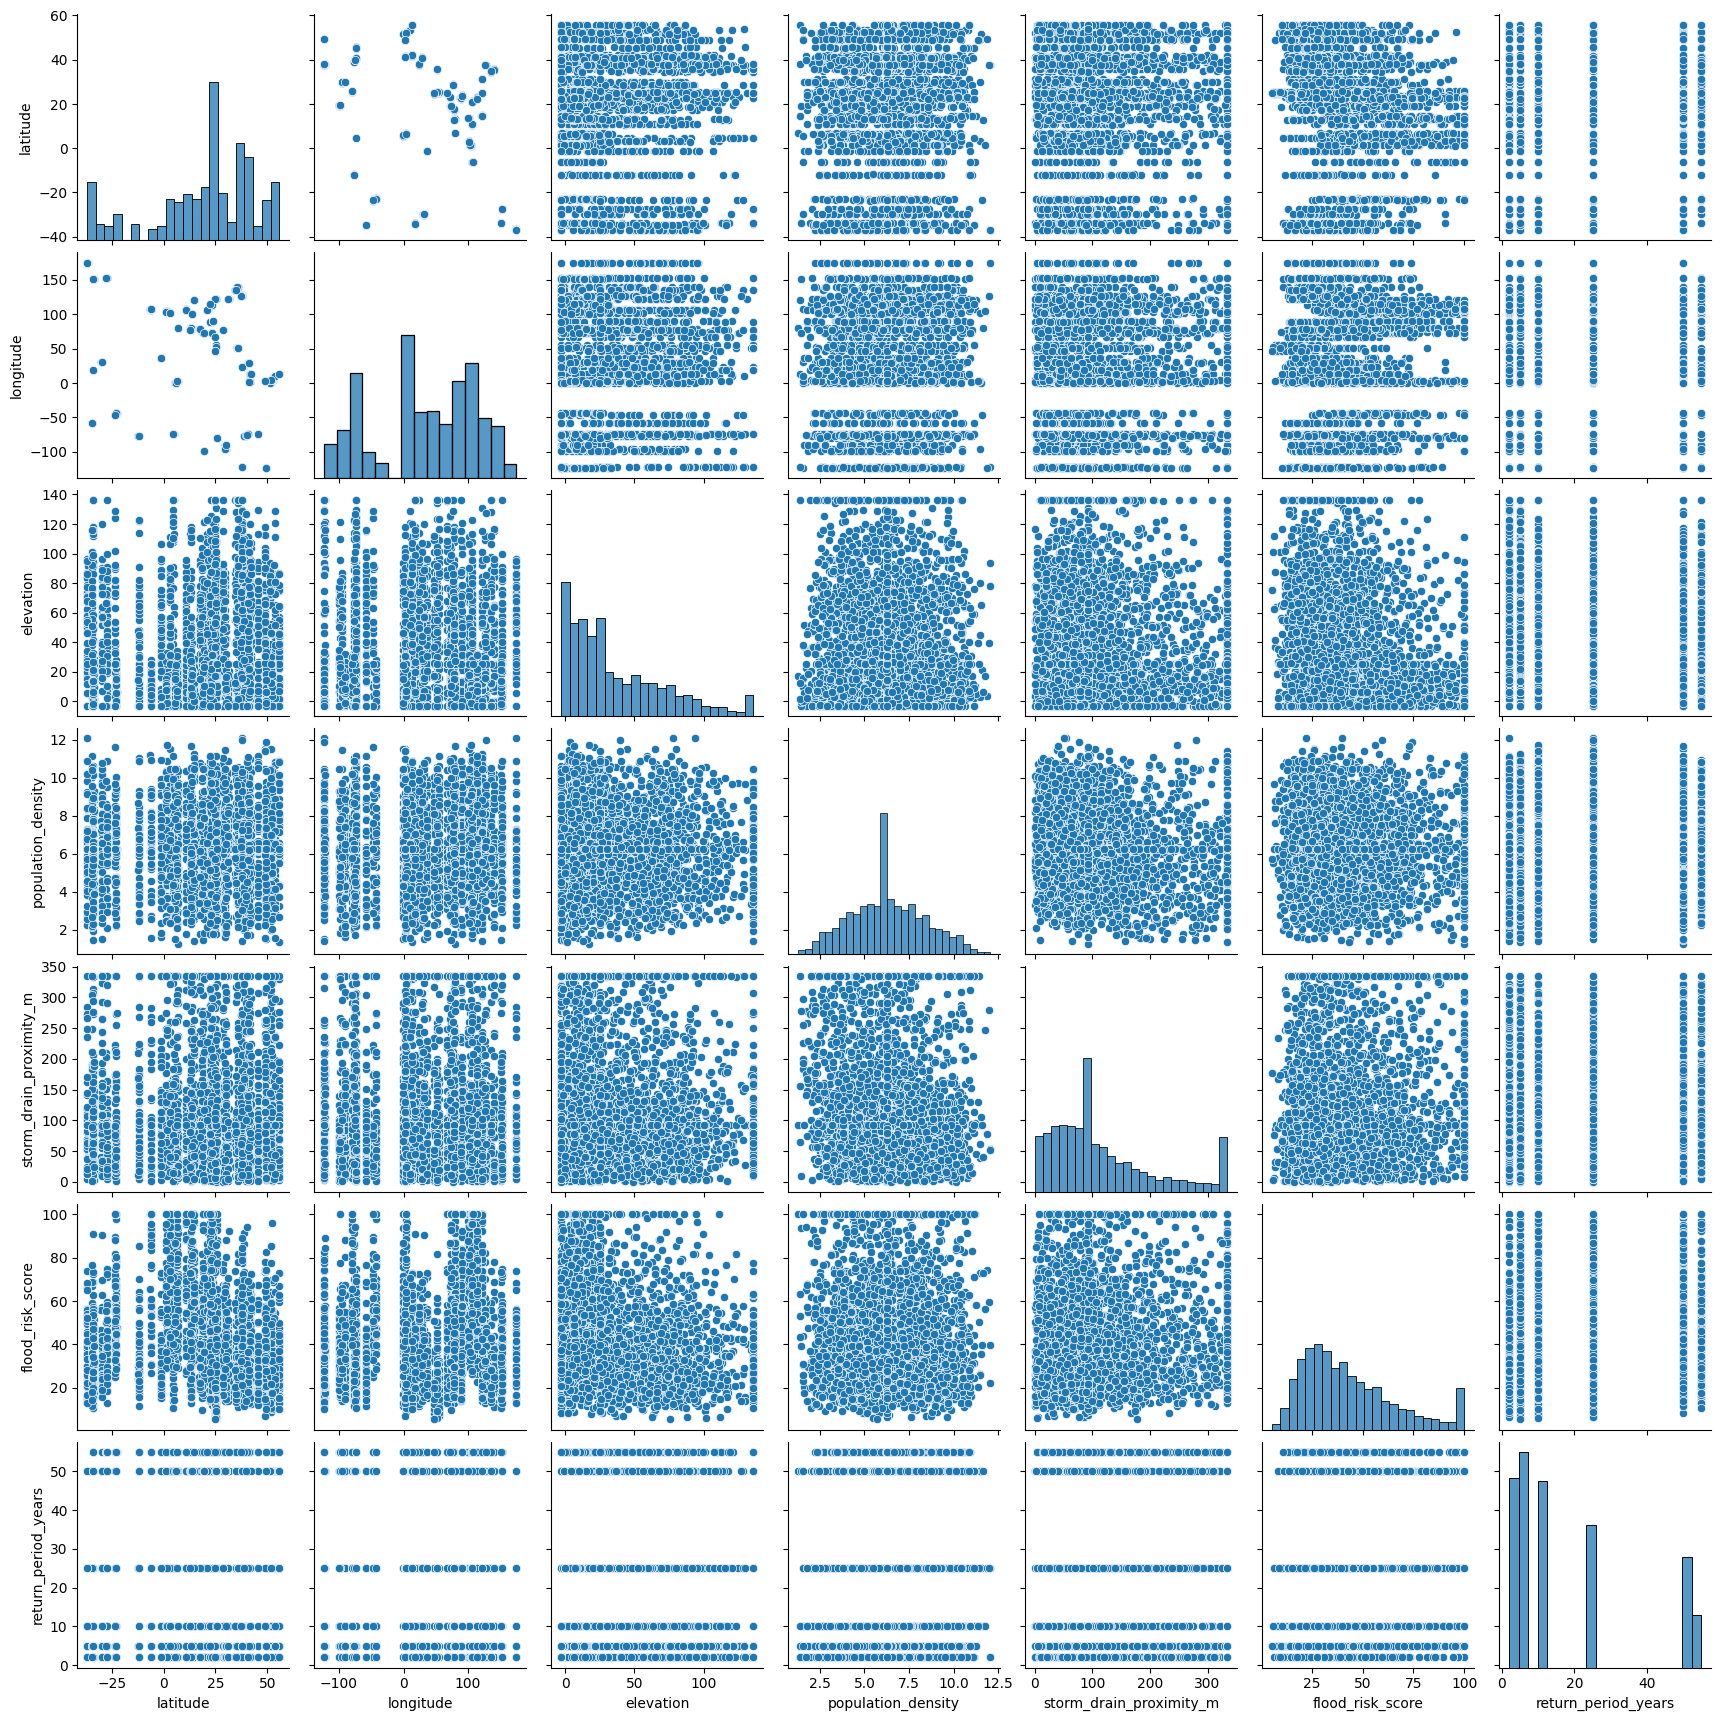

In [90]:
sns.pairplot(df.select_dtypes(include=np.number))
plt.show()

### Violin Plot of Flood Risk Score by Population Density Category

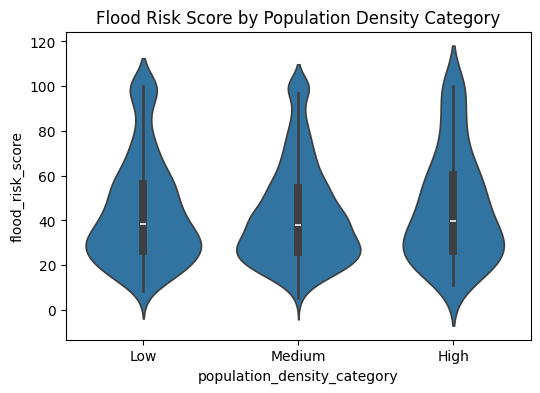

In [91]:
plt.figure(figsize=(6,4))
sns.violinplot(df, x='population_density_category', y='flood_risk_score')
plt.title('Flood Risk Score by Population Density Category')
plt.show()

### Barplot of Flood Risk Level by Elevation Category

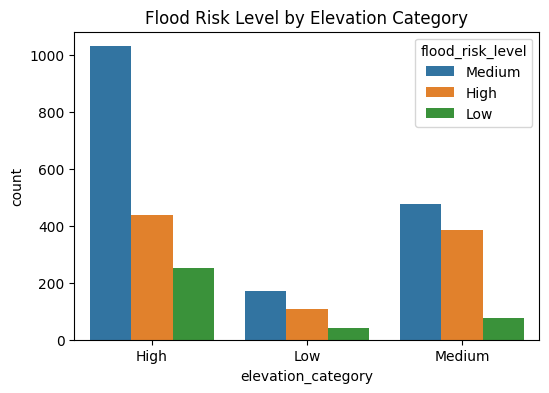

In [92]:
plt.figure(figsize=(6,4))
sns.countplot(df, x='elevation_category', hue='flood_risk_level')
plt.title('Flood Risk Level by Elevation Category')
plt.show()

## Conclusion

In [93]:
# Summary of Key Findings
print("📊 Dataset Overview:")
print(f"   - Total records after cleaning: {df.shape[0]}")
print(f"   - Flood risk level distribution: {df['flood_risk_level'].value_counts().to_dict()}")

print("\n🔍 Key Insights:")
print("   - Significant negative correlation between elevation and flood risk score (p < 0.05)")
print("   - No significant correlation between population density and flood risk score")
print("   - Significant associations between flood risk levels and elevation categories (Chi-square p < 0.05)")
print("   - Most numerical variables do not follow normal distribution")

print("\n🏗️ Data Processing:")
print("   - Missing values filled with mode (categorical) and median (numerical)")
print("   - Outliers capped using IQR method")
print("   - Feature engineering: Created risk categories and density/elevation categories")

print("\n💡 Recommendations:")
print("   - Focus flood mitigation efforts on low-elevation areas")
print("   - Monitor high-risk locations identified in the analysis")
print("   - Use this data for urban planning to reduce pluvial flood vulnerabilities")

📊 Dataset Overview:
   - Total records after cleaning: 2963
   - Flood risk level distribution: {'Medium': 1674, 'High': 926, 'Low': 363}

🔍 Key Insights:
   - Significant negative correlation between elevation and flood risk score (p < 0.05)
   - No significant correlation between population density and flood risk score
   - Significant associations between flood risk levels and elevation categories (Chi-square p < 0.05)
   - Most numerical variables do not follow normal distribution

🏗️ Data Processing:
   - Missing values filled with mode (categorical) and median (numerical)
   - Outliers capped using IQR method
   - Feature engineering: Created risk categories and density/elevation categories

💡 Recommendations:
   - Focus flood mitigation efforts on low-elevation areas
   - Monitor high-risk locations identified in the analysis
   - Use this data for urban planning to reduce pluvial flood vulnerabilities
